Yea we train in Jupyter now, deal with it.

In [1]:
import numpy as np

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from torch.utils.data import WeightedRandomSampler

from assembly_extract import OPS_LENGTH
from config import *

import random

import networkx as nx
import matplotlib.pyplot as plt

C:\Users\tanas\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_graph(G, color = None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos = nx.spring_layout(G, seed = 42), with_labels = False,
                     node_size = 32, node_color = color, cmap = "Set2")
    plt.show()


def visualize_embedding(h, color = None, epoch = None, loss = None):
    plt.figure(figsize = (7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s = 140, cmap = "Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize = 16)
    plt.show()

In [4]:
dataset = torch.load('data/dataset16N.pt')
random.shuffle(dataset)

print(f"Amount of items: {len(dataset)}")

bn = 0
rs = 0

for d in dataset:
    if d.y.item() == 1:
        rs += 1
    elif d.y.item() == 0:
        bn += 1

print(f"Amount of ransomware: {rs}")
print(f"Amount of benign: {bn}")

data_len = len(dataset)
train_amo = round(data_len * 0.8)

train_data = dataset[:train_amo]
test_data = dataset[train_amo:]

bn = 0
rs = 0

for d in train_data:
    if d.y.item() == 1:
        rs += 1
    elif d.y.item() == 0:
        bn += 1
        
class_weight = [1 / bn, 1 / rs]
sample_weight = torch.from_numpy(np.array([class_weight[data.y] for data in train_data]))
sampler = WeightedRandomSampler(sample_weight.type(torch.DoubleTensor), len(sample_weight))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, sampler = sampler)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Amount of items: 6980
Amount of ransomware: 5001
Amount of benign: 1979


AttributeError: 'numpy.ndarray' object has no attribute 'type'

Number of graphs: 6980
Data(x=[388, 16], edge_index=[2, 408], y=[1])


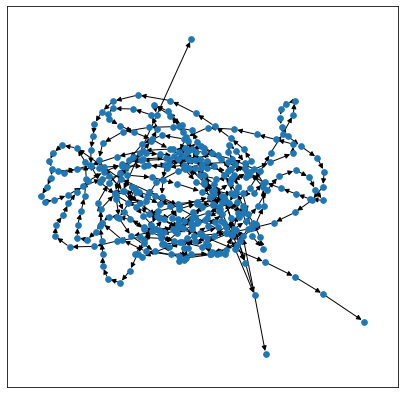

In [ ]:
from torch_geometric.utils import to_networkx

print(f'Number of graphs: {len(dataset)}')

data = dataset[14]
print(data)
G = to_networkx(data, to_undirected = False)
visualize_graph(G)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, embed_dim = 16):
        super(GCN, self).__init__()
        
       # self.embed = nn.Embedding(OPS_LENGTH, embed_dim)
        self.conv1 = GCNConv(OPS_LENGTH, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 2)
        # self.lin = nn.Sequential(
        #     nn.Linear(hidden_channels, 128),
        #     nn.Sigmoid(),
        #     nn.Linear(128, 64),
        #     nn.Sigmoid(),
        #     nn.Linear(64, 2)
        # ) 

    def forward(self, x, edge_index, batch):
        #print(f"input shape : {x.shape}")
        #print(f"edge shape : {edge_index.shape}")
        #x = self.embed(x)
        
        #print(f"embeded shape : {x.shape}")
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p=0.5, training=self.training)
        #print(f"Pre lin shape : {x.shape}")
        x = self.lin(x)
        
        return x

In [ ]:
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(OPS_LENGTH, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import F1Score

EPOCH = 20
latent_dim = 64
embed_dim = 1260

model = GCN(hidden_channels = latent_dim, embed_dim = embed_dim)
#model = GAT(hidden_channels = latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

print(f"Parameter count: {len(list(model.parameters()))}")
print(model)

Parameter count: 8
GCN(
  (conv1): GCNConv(16, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
def train():
    model.train()

    for data in tqdm(train_loader):
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad()  

def test(loader):
    model.eval()

    Apred = []
    Atarg = []
    
    for data in loader:  
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim = 1)  
        
        Apred.append(pred)
        Atarg.append(data.y)
        
    Apred = torch.concat(Apred)
    Atarg = torch.concat(Atarg)
    f1 = F1Score(num_classes = 2)
    
    return f1(Apred, Atarg).item()

f1 = []
best = 0

for e in range(EPOCH):
    #print(f"Training epoch {e}")
    train()
    test_f1 = test(test_loader)
    f1.append(test_f1)
    
    if test_f1 > best:
        best = test_f1
        torch.save(model.state_dict(), WEIGHT_PATH)
    
    print(f'Epoch: {e:03d}, Test F1: {test_f1:.4f}, Best F1: {best:.4f}')

plt.plot(f1)
plt.show()

 24%|██▍       | 21/88 [01:33<04:58,  4.46s/it]


KeyboardInterrupt: 

## Load & Interence

In [ ]:
inference_model = GCN(hidden_channels = latent_dim)
inference_model.load_state_dict(torch.load(WEIGHT_PATH))
inference_model.eval()

print(len(list(inference_model.parameters())))

6


In [ ]:
from dismgrp import dismgrp

def isRansom(path):
    PE_PATH = "../pe/benign/AAMLauncher.exe"
    try:
        data = dismgrp(PE_PATH)
    except Exception as e:
        raise e
    res = inference_model(data.x, data.edge_index, data.batch)  
    
    pre = torch.argmax(res)
    return res, pre

In [ ]:
import os

p = "../pe/benign/"
for f in os.listdir(p)[:10]:
    try:
        print(dismgrp(p + f))
    except Exception:
        continue

Data(x=[1414, 5], edge_index=[2, 1467])
Data(x=[2647, 5], edge_index=[2, 2726])
Data(x=[7073, 5], edge_index=[2, 7393])
Data(x=[19114, 5], edge_index=[2, 19793])
Data(x=[62870, 5], edge_index=[2, 67215])
Data(x=[63360, 5], edge_index=[2, 67711])
Data(x=[44384, 5], edge_index=[2, 47451])
Data(x=[324490, 5], edge_index=[2, 330168])
Data(x=[20320, 5], edge_index=[2, 21629])
